In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_color_codes('deep')

In [3]:
RANDOM_STATE = 112

# Loading data

In [4]:
import sklearn.datasets
digits_dataset = sklearn.datasets.load_digits()
digits = pd.DataFrame(digits_dataset.data)
labels = pd.Series(digits_dataset.target, index=digits.index, name='label')

THRESHOLD = np.mean(digits.values.reshape(-1))
binary_digits = digits >= THRESHOLD

from sklearn.utils import shuffle
binary_digits = shuffle(binary_digits, random_state=RANDOM_STATE)
labels = labels.loc[binary_digits.index]

In [5]:
K=len(labels.unique())
D=len(binary_digits.columns)

In [6]:
def draw_digit(row, vmin=0, vmax=1, square=True, **kwargs):
    return sns.heatmap(row.astype(float).reshape(8, 8), square=square, vmin=vmin, vmax=vmax, **kwargs)

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


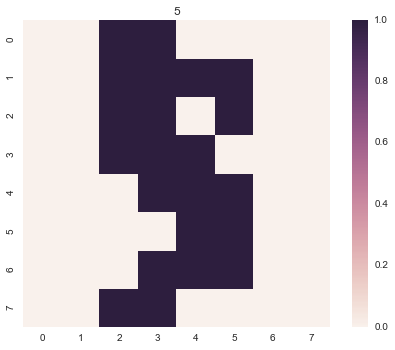

In [7]:
draw_digit(binary_digits.iloc[0])
plt.title(labels.iloc[0])

In [8]:
up_missing = binary_digits.iloc[:len(binary_digits)//4].copy()
bottom_missing = binary_digits.iloc[len(binary_digits)//4:len(binary_digits)//2].copy()
even_missing = binary_digits.iloc[len(binary_digits)//2:].copy()
up_missing.iloc[:, :D//2] = None
bottom_missing.iloc[:, D//2:] = None
even_missing.iloc[:, np.arange(0, D, 2)] = None

up_missing['dataset_id'] = 'up_missing'
bottom_missing['dataset_id'] = 'bottom_missing'
even_missing['dataset_id'] = 'even_missing'

training_data = pd.concat((up_missing, bottom_missing, even_missing))

In [9]:
training_data['weight'] = 1

In [10]:
def label_distribution(data, labels):
    ans = data[['dataset_id', 'weight']].join(labels).groupby(['dataset_id', 'label']).sum()['weight']
    ans /= ans.sum(level='dataset_id')
    
    return ans

In [11]:
from bernoullimix.random_initialisation import random_mixture_generator
N_MIXTURES_TO_TRAIN = 50
K=2

# Constraining mixing coefficients for datasets

In [12]:
training_data_same_dataset = training_data.copy()
training_data_same_dataset['dataset_id'] = 'merged'

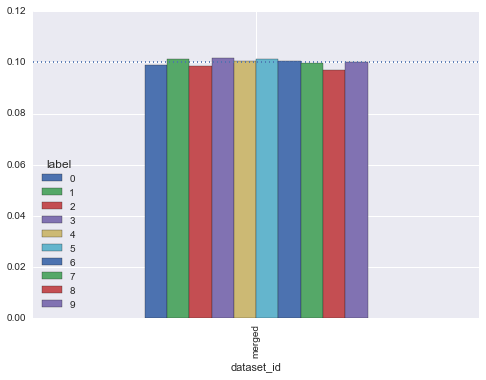

In [13]:
label_distribution(training_data_same_dataset, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [14]:
%%time
from bernoullimix.n_components_search import search_k

results, mixtures = search_k(range(2, 16), training_data, mixtures_per_k=N_MIXTURES_TO_TRAIN, random_state=RANDOM_STATE, 
                             verbose=False, eps=1e-4, n_iter=None, n_jobs=8)

CPU times: user 2.18 s, sys: 225 ms, total: 2.4 s
Wall time: 16min 35s


/Users/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/Users/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/Users/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/Users/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLU

In [15]:
results

n_components,converged,n_iterations,log_likelihood,BIC
2,1,114,-23287.015052,47570.715331
3,1,402,-22339.582619,46177.940015
4,1,213,-21766.196024,45533.256376
5,1,654,-21418.285546,45339.524971
6,1,226,-21035.969459,45076.982348
7,1,188,-21042.186910,45591.506799
8,1,340,-20632.059822,45273.342173
9,1,269,-20554.210249,45619.732577
10,1,289,-20322.137248,45657.676127
11,1,328,-20286.258963,46088.009108


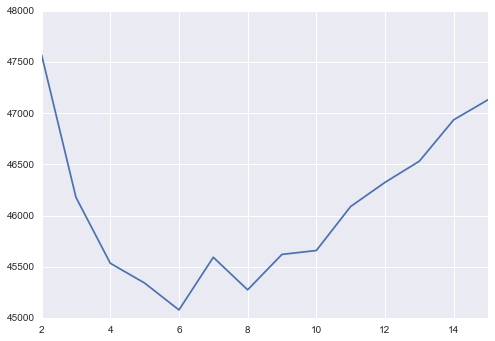

In [17]:
results['BIC'].plot()

In [ ]:
mixture = mixtures[7]
plt.figure(figsize=(15,15))
for j, (component, row) in enumerate(mixture.emission_probabilities.iterrows(), start=1):
    plt.subplot(4,3,j)
    draw_digit(row)
    plt.title(component)
plt.suptitle('Mixture K={}'.format(mixture.n_components))

In [ ]:
raise Exception

In [ ]:
import itertools
mixtures = list(itertools.islice(random_mixture_generator(K, 
                                                          training_data_same_dataset, 
                                                          random_state=RANDOM_STATE), 
                                 N_MIXTURES_TO_TRAIN))

In [ ]:
%%time
fit_results = []

for i, mixture in enumerate(mixtures):
    print('Fitting #{}'.format(i))
    
    result = mixture.fit(training_data_same_dataset, eps=1e-4, verbose=False, n_iter=None)
    print(result)
    fit_results.append(result)  
    

In [ ]:
log_likelihoods = [x[2] for x in fit_results]

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure()
    mixture.mixing_coefficients.T.plot(kind='bar')
    plt.title('Mixture #{}. LL={}'.format(i, fit_results[i][2]))

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure(figsize=(15,15))
    for j, (component, row) in enumerate(mixture.emission_probabilities.iterrows(), start=1):
        plt.subplot(4,3,j)
        draw_digit(row)
        plt.title(component)
    plt.suptitle('Mixture #{}. LL={}'.format(i, fit_results[i][2]))
        

# Unconstrained mixture

In [ ]:
label_distribution(training_data, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [ ]:
import itertools
mixtures = list(itertools.islice(random_mixture_generator(K, 
                                                          training_data, 
                                                          random_state=RANDOM_STATE), 
                                 N_MIXTURES_TO_TRAIN))

In [ ]:
%%time
fit_results = []

for i, mixture in enumerate(mixtures):
    print('Fitting #{}'.format(i))
    
    result = mixture.fit(training_data, eps=1e-4, verbose=False, n_iter=None)
    print(result)
    fit_results.append(result)  
    

In [ ]:
log_likelihoods = [x[2] for x in fit_results]

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure()
    mixture.mixing_coefficients.T.plot(kind='bar')
    plt.title('Mixture #{}. LL={}'.format(i, fit_results[i][2]))

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure(figsize=(15,15))
    for j, (component, row) in enumerate(mixture.emission_probabilities.iterrows(), start=1):
        plt.subplot(4,3,j)
        draw_digit(row)
        plt.title(component)
    plt.suptitle('Mixture #{}. LL={}'.format(i, fit_results[i][2]))